# Data For Teams
> "Excel at Python"

- author: Dmytro Karabash, Maxim Korotkov 
- categories: [management, python]
- image: images/analysis-1841158_1920.jpg
- permalink: /fastreport/

In [382]:
#hide
##loading functions

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

#multiple outputs (from ​​​​28 Jupyter Notebook Tips, Tricks, and Shortcuts)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

verbosity=5

## Introduction

You’re the boss now. You have a team or a business unit doing consultancy. Probably a bunch of Consultants helping clients, some Project Managers leading your projects in a nice Agile or whatever way. Everyone fills their timesheets (and you cut their bonuses if they don’t) – time is billed to clients and you have Fixed Fee projects also. Maybe smaller teams being parts of your team also – you can lead ten, hundred or thousand people (hey, dude – you run a unit of 1000 employees? Don’t read this article – hire someone who did) You probably even have an ERP or something and a CFO in a nice corner office. Do you have a good way to estimate how much profit every team member and project brings and ways to predict it with good precision? If you have a nice ERP dashboard which gives you all that – then you’re lucky and you don’t need this article either. But high chances are that you get a simple calculation end of year – like “let’s take all revenue finance recognized on your projects in a year and man day cost at USD 800 to get your unit profitability” (USD 800 can seem crazily high or unacceptably low, depending on business you’re in). So that’s the precision you have to count the money your team brings to firm? Do we need to remind you that this is the only reason why your job exists?

What else can you get – all the timesheets, projects with their budgets and you can even get to approximate costs (let's discuss it later). Shitload of data for a year even for a team of 10. What I will tell you here is that you don’t need an ERP to do the rest – the notebook in Jupyter will do. Let’s remember - management starts with measurement. How can you supervise your team and projects if you don’t have their data at your fingers?

Why do you need Data Science here? Well, you can have all data at your fingers. Eventually you would want to calculate your profit like
```python
profit = revenue - cost
```

Not only as subtracting two numbers, but also on the level of tables - so output of above statement can be actualy a table with profit per consultant per month, like this:

In [411]:
#hide
#Dmytro TODO: how to show $ in jupyter, colab and fastpages? I've tried \$, \\$, '$', $\$$ and <span>$</span>. 
#merely a sample, no meaning at all - skip it please
profit = pd.DataFrame([[6187.500,8006.25],[8050.000,3762.50]], index =['CATTY THE NEW MANAGER', 'FRANK THE CONSTULANT'], 
                                              columns =['2020-02', '2020-03'])

In [408]:
profit

,2020-02,2020-03
CATTY THE NEW MANAGER,6187.5,8006.25
FRANK THE CONSTULANT,8050.0,3762.50


Or get list of 3 people with most unbillable hours in April via following statement
```python
t.where(~t['Billable'] & (t['Month']=='2020-04')).groupby(['User'])['effort'].sum().nlargest(3)
```

The code above is indeed not executable, but we promise to get you there in a few paragraphs. And yes, there is some learning of python required. The huge difference from anything else you've been doing yourself (ERP reports, Excel, other tools) is that any analysis stays here in the notebook and can be re-applied after your data changes.

## Data Science

So, let’s get this done. First – yes, you need to know a little bit of python to get the files in. Basic level will do. (If you are a manager in 2020 and can’t write a simple script – hm, you probably missed something). The objective is not to build an ERP and not even to have an easy-to-use toolkit - we want to show you how to build toolkit for yourself (but feel free to reuse our code). hat you will see is a very simple set of examles - spend an hour or two to load your files into the notebook and then start playing with it - just make the analysis you want. You can end up checking a few numbers or building your own charts and dashboards. It is ok, even if you work for a corporation (that’s where you need it most) - just install Anaconda and download the notebook. So, we first get and transform our input files (if you want to follow text AND all the code - read it on colab)

We are loading projects, timesheets and roles below - more details will follow on what we presumed is inside.

In [383]:
data = {}
# TODO: URL vs localfiles (localfiles don't work in colab - so I'd rather go URL)
url = 'https://raw.githubusercontent.com/h17/fastreport/master/data/roles.csv'
data['roles'] = pd.read_csv(url, index_col=0,sep=";")

project_data = pd.ExcelFile('../data/project_data.xlsm')
project_data.sheet_names

['TS Feb', 'TS Mar', 'TS Apr', 'Entity Project', 'HC']

Don't focus too much on the next code block - we have monthly timesheets in separate tabs and need to stack them one on top of another. Plus - we have errors in excel (Sat.1 column) - data cleanup is also required, quite usual for those of you who've at as much as heard of data scient. Collapsed blocks in our notebook contain the code which is not critical for understanding. If you'd rather read it all - we suggest you switch to either github or colab - so you can play with it also.

In [384]:
#collapse

timesheets = []
for sheet in project_data.sheet_names:
    if 'TS' in sheet:
        timesheets += [pd.read_excel(project_data,sheet,header=2)]
    else:
        tmp = pd.read_excel(project_data,sheet)
        data[sheet] = tmp 
if 'Sat.1' in timesheets[0]: timesheets[0] = timesheets[0].rename(columns={'Sat': 'Sun', 'Sat.1' : 'Sat'}) 
data['timesheet'] = pd.concat(timesheets,sort=False)
# replease billable field by bool - helpful to simplify code
d = {'Billable': True, 'Non-Billable': False}
data['timesheet']['Billable'] = data['timesheet']['Billing'].replace(d)
_ = data['timesheet'].drop(['Billing'], axis=1, inplace=True)
data['timesheet'] = data['timesheet'][~data['timesheet'].User.isnull()]
#data.keys()

So, let's see what we've got here

In [385]:
data.keys()
for key in data.keys():
    print("{:20} shape: {:^10} rows \t and {:^10} columns".format(key, *data[key].shape))

dict_keys(['roles', 'Entity Project', 'HC', 'timesheet'])

roles                shape:     9      rows 	 and     5      columns
Entity Project       shape:     48     rows 	 and     15     columns
HC                   shape:     35     rows 	 and     6      columns
timesheet            shape:    1792    rows 	 and     14     columns


## Data we loaded

Let me summarize it here – in any decent firm, if you are a team leader or business unit manager – you can get
* Dictionaries
    * Cost per region or default cost for “outside” contributors
    * Average revenue per hour for projects not “owned” by you
    

In [386]:
# show roles
roles=data["roles"]
# dmytro TODO: here we'd need to stack it on last 3 countries, for now I've used "EU" but that's wrong
roles.head()
def_revenue = 1200
def_cost = 850

,Position,Level,EU,UK,CH
Position Name,,,,,
DIRECTOR,DIR,SENIOR,1100,1300,1100
Program Manager,PRA,SEASONED,900,1000,900
Project Manager,PRO,SENIOR,800,800,800
Project Coordinator,PRO,SEASONED,700,700,700
Solution Architect,CON,EXPERT,900,1000,1050


* HeadCount
    * List of your employees, with their grades (or costs)
    * Engagement model (employee or contractor)

In [387]:
#show head count
headcount=data["HC"]
# dmytro TODO: use stacked column instead of EU
headcount = headcount.merge(roles[['Position','Level','EU']],how='left',left_on=['Level','Position'],right_on=['Level','Position'])
headcount.head(n=5)

,NAME,TYPE,Location,Position,Level,ID,EU
0,JANE DOE,STAFF,CH,CON,SEASONED,1001,550
1,JOHN DOE,STAFF,PL,CON,JUNIOR,1002,500
2,JOHN SMITH,STAFF,CH,CON,SEASONED,1003,550
3,JACK THE MANAGER,CONTRACTOR,CH,PRO,SENIOR,1004,800
4,JOHN THE MANAGER,CONTRACTOR,CH,PRO,SENIOR,1005,800


* Projects
    * Budget, effort estimate, deadline
    * Project type (e.g. “On demand support” or “Subscription” will not have any actual deadline to control) - though it is ok if you don’t have it
    * Type of revenue recognition (Time and Material or Fixed Fee)


In [388]:
# show projects
projects = data["Entity Project"]
projects.head(n=5)

,Client ID,Project ID,Project,PM,Client Region,Start,End,Funding,BASE RATE USD,TCV,Recognized\nUSD,2017 effort,2018 effort,2019 effort,Jan 2020 Effort
0,13154,68454,Medium consutancy 1,SUSAN THE MANAGER,Europe,2019-01-16 08:00:00,2020-07-22 14:00:00,Time and Materials,1200,"39,000 EUR",41540.0800,0,0.0,180.5,21.50
1,2764,70285,Our biggest project,EXT 6a8e0ca747,Europe,2019-10-01 08:00:00,2021-04-30 11:00:00,Time and Materials,1200,"1,450,999 USD",473002.0800,0,0.0,1241.5,458.25
2,12916,68093,Upgrade to new version,TIM THE LEAVER,Europe,2018-09-28 08:00:00,2020-04-27 17:00:00,Fixed Fee,1200,"127,500 EUR",142411.5533,0,0.0,0.0,0.00
3,12916,68094,Small change on top of upgrade,JOHN THE MANAGER,Europe,2018-09-28 08:00:00,2020-05-11 17:00:00,Time and Materials,1200,"12,500 EUR",0.0000,0,0.0,0.0,0.00
4,18933,68726,Transition from another product,JANE THE MANAGER,Europe,2019-03-01 08:00:00,2020-05-27 16:00:00,Fixed Fee,1200,"143,250 EUR",132677.3616,0,0.0,525.5,5.00


* Timesheets (your team / your projects, note that other teams can contribute to your projects and your team might work in other projects) 
    * Typically arrive monthly or weekly
    * (optional) Plans
        * If there are no plans, in one of next options we'll talk about an option to “plan auto-fill”

In [389]:
# show timesheets

timesheet=data["timesheet"]
timesheet.head(n=5)

,Project,Activity,User,Period Starting,Effort Type,Total (Days),Sun,Mon,Tue,Wed,Thu,Fri,Sat,Billable
0,PRJ d41d8cd98f,Consultancy,EXT 800982ab08,2020-02-02,Actual,2.5,0.0,0.5,0.5,0.5,0.5,0.5,0.0,True
1,PRJ d41d8cd98f,Consultancy,EXT c8c92ca432,2020-02-02,Actual,2.5,0.0,0.5,0.5,0.5,0.5,0.5,0.0,True
2,PRJ d41d8cd98f,Consultancy,EXT c8c92ca432,2020-02-09,Actual,2.5,0.0,0.5,0.5,0.5,0.5,0.5,0.0,True
3,PRJ d41d8cd98f,Consultancy,EXT 800982ab08,2020-02-09,Actual,2.5,0.0,0.5,0.5,0.5,0.5,0.5,0.0,True
4,PRJ d41d8cd98f,Consultancy,EXT c8c92ca432,2020-02-16,Actual,2.5,0.0,0.5,0.5,0.5,0.5,0.5,0.0,True


EXT users here are the ones not registered in our HeadCount (let's say we are not getting the real names, but rather some ids from ERP in such case)

Why not just have things done by ERP? Well, your ERP probably does not present you anything nicely in terms of parameters you’d want to control on your level  (otherwise you won’t read this anyway). There is even maybe a project running to improve it by 2025 - maybe one of Big4 firms is interviewing you for requirements. If you are steering this boat long enough – you might have ended up with quick and dirty calculation, SQL queries to SAP (with field names still in German) or an Excel file. Why? Because, well, your bosses don’t care – they already hired you and a better ERP is coming in 2025 anyway – so they want to know how much money your team makes (preferably - per person, per month, per project) and to know why is it not so profitable (because it never is).

To simplify your way forward we are going to create a timeseries out of timesheets which is a bit more involved so you can skip it for now and come back to it later, but the point is that at the end you will get a nice monthly pandas Dataframe that looks like this

In [390]:
#collapse

dd=[]
timesheet['Period Starting'] = pd.to_datetime(timesheet['Period Starting'])
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'] 
for i, weekday in enumerate(weekdays):
    columns = [col for col in timesheet if col not in weekdays or col==weekday]
    tmp = timesheet[columns].copy() #dmytro todo: port backward
    tmp = tmp.rename(columns={weekday: 'effort'})
    tmp['date'] = tmp['Period Starting']+pd.to_timedelta('{}D'.format(i)) #dmytro todo: check period starting offset logic
    tmp['weekday'] = weekday
    tmp = tmp.drop(['Period Starting','Total (Days)'],axis=1)
    dd +=[tmp]

timeseries = pd.concat(dd,sort=False).sort_values(['User','date'])
timeseries = timeseries.reset_index().drop('index',axis=1)
timeseries['date'] = pd.to_datetime(timeseries['date']).astype('str')
timeseries['month'] = timeseries['date'].str[:7] # dmytro todo: maybe improve date, month stylistics 
timeseries['weekend'] = timeseries['weekday'].apply(lambda x: x in ['Sun','Sat'])
timeseries['workweek'] = timeseries['weekday'].apply(lambda x: x not in ['Sun','Sat'])
timeseries.head(5)
#dmytro todo: clean almost null rows

,Project,Activity,User,Effort Type,effort,Billable,date,weekday,month,weekend,workweek
0,Upgrade in two contracts - 1,Consultancy,CATTY THE NEW MANAGER,Actual,0.000,True,2020-02-16,Sun,2020-02,True,False
1,Upgrade in two contracts - 2,Consultancy,CATTY THE NEW MANAGER,Actual,0.000,True,2020-02-16,Sun,2020-02,True,False
2,A pilot for huge opportunity,Consultancy,CATTY THE NEW MANAGER,Actual,0.000,True,2020-02-16,Sun,2020-02,True,False
3,A pilot for huge opportunity,Consultancy,CATTY THE NEW MANAGER,Actual,0.000,False,2020-02-16,Sun,2020-02,True,False
4,Upgrade in two contracts - 1,Consultancy,CATTY THE NEW MANAGER,Actual,0.375,True,2020-02-17,Mon,2020-02,False,True


It is very typical in data science to do it this (or to unstack dates) so that you can group and filter easily.

In [391]:
#timeseries_wide = timeseries.groupby(list(timeseries.columns.drop('effort'))[:2])['effort'].sum()
#.unstack('date').reset_index().fillna(0)

In [392]:
#timeseries.groupby('User')['effort'].sum()#.unstack('date').reset_index().fillna(0)

## Profitability

Timesheets and projects budgets are now simple and you can manipulate them the way you want in few simple statements. If you studied excel formulas - you can do this also. Now, let's look at profitability in a simplest manner possible. Being a manager I suggest you do that to set benchmarks for you team. So, profit is Revenue – Cost and we intend to keep it simple. Having said that, you can implement the calculations you like. 

**Revenue**: Let’s say that for a Time & Material project you generate as much revenue as you bill (on agreed rate) up to its budget. For a Fixed Fee you split all the revenue per month as % of effort you spend / are going to spend in the month (changes can be complicated, but they are easy to be managed in the way you want)

Let's assume that we are interested only by users in our headcount (so we filter out all _EXT_ users)

In [410]:
# revenue calculation for a person for a month (SUM REV of all timesheet records * corresp project rates)
revenue_df = timeseries[['User','Project','Billable','effort','date','month']].merge(projects[['Project','BASE RATE USD']],how='left',on='Project')
revenue_df['BASE RATE USD'] = revenue_df['BASE RATE USD'].fillna(def_revenue)
# todo: Dmytro - anything simpler to remove all starting with "EXT" than lambda?
revenue_df = revenue_df.where(revenue_df['User'].map(lambda x: x[:3]!='EXT')).dropna()
revenue_df = revenue_df.where(revenue_df['Billable']).dropna()
# MAX TODO: implement FF revenue
revenue_df['daily_revenue'] = revenue_df['BASE RATE USD'] * revenue_df['effort']
revenue = revenue_df.groupby(['User','month'])['daily_revenue'].sum().unstack().fillna(0)
revenue = revenue[revenue.sum(1)>0]
revenue.head()
#dmytro todo: check null effort, do smart groupby

month,2020-02,2020-03,2020-04
User,,,
CATTY THE NEW MANAGER,11550.000,19350.00,9412.500
FRANK THE CONSTULANT,15750.000,12425.00,14875.000
IVAN THE PROGRAMMER,25062.500,29043.75,25643.750
JACK THE EXPERT,29093.750,31331.25,24843.750
JACK THE MANAGER,24090.625,22318.75,18821.875


So we got revenue per month per person. Not too complicate, right?

**Cost**: So, let’s start with the fact that just using the "default cost rate" is not enough - whenever margins are under pressure you should do better. You might have people working in different countries and of totally different levels. Talk to your finance team and get some estimates from them (or make it together). We’d say if you were appointed to run a team or business unit – they owe you that much. We will assume below that you managed to get few grades per Country (see _roles_).  Costs per individual will go nicely also and the beauty of this tool (compared to doing few excels by yourself) is that you can just add it - for all of your staff or some some, it will be 1 line of code. Let's calculate direct cost per momnth (here we check the cost of effort posted on timesheets, presuming they are full - can check per number of working days in a month also and compare. We are not interested in external resources, so we'll filter them out

In [394]:
# cost calculation for a project (SUM COST of all timesheet records * corresp cost rates - see roles)
cost_df = timeseries[['User','Project','effort','date','month']].merge(headcount[['NAME','EU']],how='left',left_on='User',right_on='NAME')
cost_df['EU'] = cost_df['EU'].fillna(def_cost)
# todo: Dmytro - anything simpler to remove all starting with "EXT" than lambda?
cost_df = cost_df.where(cost_df['User'].map(lambda x: x[:3]!='EXT')).dropna()
cost_df['daily_cost'] = cost_df['EU'] * cost_df['effort']
cost = cost_df.groupby(['User','month'])['daily_cost'].sum().unstack().fillna(0)
cost = cost[cost.sum(1)>0]
cost.head()
# cost_df.effort.sum()
# cost.shape
# cost.sum()
#dmytro todo: check null effort, do smart groupby

month,2020-02,2020-03,2020-04
User,,,
CATTY THE NEW MANAGER,5362.50,11343.75,9332.8125
FRANK THE CONSTULANT,7700.00,8662.50,7768.7500
IVAN THE PROGRAMMER,11481.25,12925.00,11618.7500
JACK THE EXPERT,18750.00,20350.00,17100.0000
JACK THE MANAGER,11800.00,10900.00,9600.0000


Now, we can get to profit per user per month using operations on dataframes. And here it bears some fruit. _Profit = revenue - cost_. Indeed, it required some data cleanup first - but not too much

In [395]:
profit = revenue - cost
profit.head()

month,2020-02,2020-03,2020-04
User,,,
CATTY THE NEW MANAGER,6187.500,8006.25,79.6875
FRANK THE CONSTULANT,8050.000,3762.50,7106.2500
IVAN THE PROGRAMMER,13581.250,16118.75,14025.0000
JACK THE EXPERT,10343.750,10981.25,7743.7500
JACK THE MANAGER,12290.625,11418.75,9221.8750


That's what we've promised, right? Ok, second one - people who entered most Non-Billable hours in April

In [396]:
timeseries.where(~timeseries['Billable'] & (timeseries['month']=='2020-04')).groupby(['User'])['effort'].sum().nlargest(3)

User
CATTY THE NEW MANAGER    9.125000
EXT 6d5bda8573           6.933333
EXT 7bdf4bf350           5.000000
Name: effort, dtype: float64

## More compex stuff

Now let's actually show how to apply data science to data you've seen above

First, some fun for those who want to learn python - you can make an interactive chart in few lines, e.g. here we want to make it visual in terms of if the value is above or below benchmark (works if you copy notebook, is not clickable in fastpages)

<IPython.core.display.Javascript object>


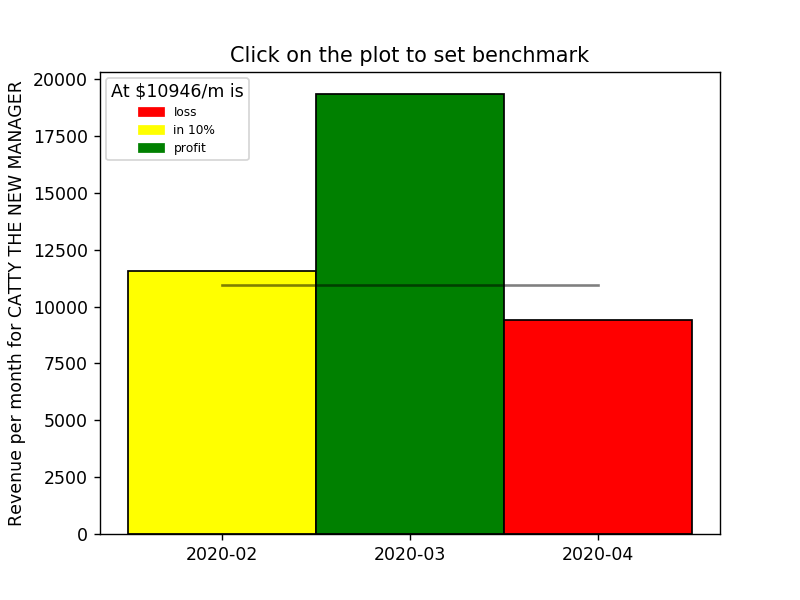

In [397]:
#collapse

# dmytro TODO: code review
# dmytro TODO: this 
# 1. Is only rendered in fastpages (which is semi-ok)
# 2. Does not work on colab (which is not that nice)

%matplotlib notebook

u_input = "CATTY THE NEW MANAGER"
drawdt = revenue.loc[u_input].T
 
# colors of bars
def get_colors(v):
    colors = []
    for i in range(len(drawdt.index)):
        color = "yellow"
        if (drawdt[i] < v*0.9):
            color = "red"
        if (drawdt[i] > v*1.1):
            color = "green"
        colors.append(color)
    return colors   

# plot drawing
def plt_all(isdef, yvalue):
    if isdef:
        bcolors = "white"
        xtitle = 'Set value'
    else:
        a = np.empty(len(drawdt.index))
        a.fill(yvalue)
        plt.plot(range(len(drawdt.index)), a, color="black",alpha=0.5)
        bcolors = get_colors(yvalue)
        xtitle = 'At ${:.0f}/m is'.format(yvalue)
    plt.bar(range(len(drawdt.index)), drawdt.values, color=bcolors, width = 1, align='center', edgecolor='black')
    plt.xticks(range(len(drawdt.index)), drawdt.index)
    plt.ylabel("Revenue per month for "+u_input)
    red_patch = mpatches.Patch(color='red', label='loss')
    yellow_patch = mpatches.Patch(color='yellow', label='in 10%')
    green_patch = mpatches.Patch(color='green', label='profit')
    plt.legend(handles=[red_patch,yellow_patch,green_patch],loc='upper left',title = xtitle,fontsize=7)
    plt.gca().set_title('Click on the plot to set benchmark')

plt_all(True,0.0)

def onclick(event):
    plt.cla()
    plt_all(False,event.ydata)

_ = plt.gcf().canvas.mpl_connect('button_press_event', onclick)

Ok, as a Team Leader you might not do that. Sorry. Let's get some calculations done. First, let's identify "suspicios" behaviors (e.g. a person who has more then 5 days in a row same effort on a given project and it is not 8 hours) - this is a quick check you do yourself, without asking PMO anything and making this official

In [398]:
# Simple anomalies detection
# TODO: call for action, intro to next paper

## Use cases

Let's just list some cases where this can be helpfull

* Decision making - e.g. identify top loss-making projects
* Identify projects which require management attention
* Identify top performers (profit-wise)
* Identify non-billable hours and internal projects
* Identify suspicious behaviours (we will write another post about it)
    * Employee enters fixed hours per project per day over a period
    * Anomaly detection
* Revenue and effort projections
* Capacity calculations: load all data but plans and generate automated projection (effort * person * month / revenue * month)
* Create consolidated analytic on demand for higher level of management (e.g. profitability forecast, revenue forecast, unallocated capacity) in case your ERP will not do anything like that
    * Example: crisis cost saving - if you decrease hours for some contractors, how much cost do you save vs how much revenue to you lose

But, that's not the point. The point is that loading your own data (excel, csv, text - whatever) is simple and manipulating it is also simple - definetely simpler then doing it in numerous excel files and faster then waiting for PMOs. 

<font size="2">
Copyright &copy; Dmytro Karabash, Maxim Korotkov; 2020. <br>  This notebook is licensed under a <a rel="license" href="https://creativecommons.org/licenses/by/4.0/">Creative
Commons Attribution 4.0 International License</a>.
</font>